# Inference

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params

set_pyplot_params()

Whenever people compare Bayesian inference with conventional approaches, one of the questions that comes up most often is something like, "What about p-values?"
And one of the most common examples is the comparison of two groups to see if there is a difference in their means.

In classical statistical inference, the usual tool for this scenario is a [Student's *t*-test](https://en.wikipedia.org/wiki/Student%27s_t-test), and the result is a [p-value](https://en.wikipedia.org/wiki/P-value).
This process is an example of [null hypothesis significance testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing).

A Bayesian alternative is to compute the posterior distribution of the difference between the groups.
Then we can use that distribution to answer whatever questions we are interested in, including the most likely size of the difference, a credible interval that's likely to contain the true difference, the probability of superiority, or the probability that the difference exceeds some threshold.

To demonstrate this process, I'll solve a problem borrowed from a statistical textbook: evaluating the effect of an educational "treatment" compared to a control.

## Improving Reading Ability

We'll use data from a [Ph.D. dissertation in educational psychology](https://docs.lib.purdue.edu/dissertations/AAI8807671/) written in 1987, which was used as an example in a [statistics textbook](https://books.google.com/books/about/Introduction_to_the_practice_of_statisti.html?id=pGBNhajABlUC) from 1989 and published on [DASL](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html), a web page that collects data stories.  

Here's the description from DASL:

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

The [dataset is available here](https://web.archive.org/web/20000603124754/http://lib.stat.cmu.edu/DASL/Datafiles/DRPScores.html).

The following cell downloads the data.

In [4]:
import os

if not os.path.exists('drp_scores.csv'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/drp_scores.csv

I'll use Pandas to load the data into a `DataFrame`.

In [5]:
import pandas as pd

df = pd.read_csv('drp_scores.csv', skiprows=21, delimiter='\t')
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


The `Treatment` column indicates whether each student was in the treated or control group.
The `Response` is their score on the test.


I'll use `groupby` to separate the data for the `Treated` and `Control` groups:

In [6]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

Here are CDFs of the scores for the two groups and summary statistics.

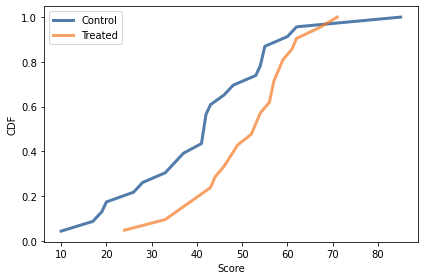

In [7]:
from empiricaldist import Cdf
from utils import decorate

for name, response in responses.items():
    cdf = Cdf.from_seq(response)
    cdf.plot(label=name)
    
decorate(xlabel='Score', ylabel='CDF')

There is overlap between the distributions, but it looks like the scores are higher in the treated group.

The distribution of scores is not exactly normal for either group, but it is close enough that the normal model is a reasonable choice.

So I'll assume that in the entire population of students (not just the ones in the experiment), the distribution of scores is well modeled by a normal distribution with unknown mean and standard deviation.
I'll use `mu` and `sigma` to denote these unknown parameters,
and we'll do a Bayesian update to estimate what they are.

## Estimating parameters

As always, we need a prior distribution for the parameters.
Since there are two parameters, it will be a joint distribution.
I'll construct it by choosing marginal distributions for each parameter and computing their outer product.

As a simple starting place, I'll assume that the prior distributions for `mu` and `sigma` are uniform.
The following function makes a `Pmf` object that represents a uniform distribution.

In [8]:
from empiricaldist import Pmf

def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

`make_uniform` takes as parameters 

* An array of quantities, `qs`, and

* A string, `name`, which is assigned to the index so it appears when we display the `Pmf`.

Here's the prior distribution for `mu`:

In [9]:
import numpy as np

qs = np.linspace(20, 80, num=101)
prior_mu = make_uniform(qs, name='mean')

I chose the lower and upper bounds by trial and error.
I'll explain how when we look at the posterior distribution.

Here's the prior distribution for `sigma`:

In [10]:
qs = np.linspace(5, 30, num=101)
prior_sigma = make_uniform(qs, name='std')

Now we can use `make_joint` to make the joint prior distribution.

In [11]:
from utils import make_joint

prior = make_joint(prior_mu, prior_sigma)

And we'll start by working with the data from the control group.

In [12]:
data = responses['Control']
data.shape

(23,)

In the next section we'll compute the likelihood of this data for each pair of parameters in the prior distribution.

## Likelihood

We would like to know the probability of each score in the dataset for each hypothetical pair of values, `mu` and `sigma`.
I'll do that by making a 3-dimensional grid with values of `mu` on the first axis, values of `sigma` on the second axis, and the scores from the dataset on the third axis.

In [13]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, data)

mu_mesh.shape

(101, 101, 23)

Now we can use `norm.pdf` to compute the probability density of each score for each hypothetical pair of parameters.

In [14]:
from scipy.stats import norm

densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

The result is a 3-D array.  To compute likelihoods, I'll multiply these densities along `axis=2`, which is the axis of the data:

In [15]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

The result is a 2-D array that contains the likelihood of the entire dataset for each hypothetical pair of parameters.

We can use this array to update the prior, like this:

In [16]:
from utils import normalize

posterior = prior * likelihood
normalize(posterior)
posterior.shape

(101, 101)

The result is a `DataFrame` that represents the joint posterior distribution.

The following function encapsulates these steps.

In [17]:
def update_norm(prior, data):
    """Update the prior based on data."""
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    densities = norm(mu_mesh, sigma_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)

    return posterior

Here are the updates for the control and treatment groups:

In [18]:
data = responses['Control']
posterior_control = update_norm(prior, data)

In [19]:
data = responses['Treated']
posterior_treated = update_norm(prior, data)

And here's what they look like:

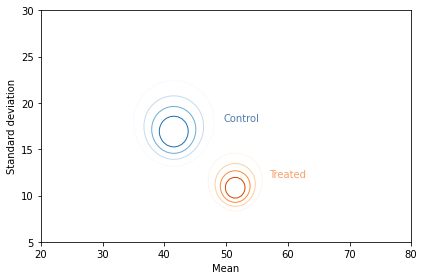

In [20]:
import matplotlib.pyplot as plt
from utils import plot_contour

plot_contour(posterior_control, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean', ylabel='Standard deviation')

Along the `x` axis, it looks like the mean score for the treated group is higher.
Along the `y` axis, it looks like the standard deviation for the treated group is lower.

If we think the treatment causes these differences, the data suggest that the treatment increases the mean of the scores and decreases their spread.
We can see these differences more clearly by looking at the marginal distributions for `mu` and `sigma`.

## Posterior marginal distributions

I'll use `marginal`, which we saw in <<_MarginalDistributions>>, to extract the posterior marginal distributions for the population means.

In [21]:
from utils import marginal

pmf_mean_control = marginal(posterior_control, 0)
pmf_mean_treated = marginal(posterior_treated, 0)

Here's what they look like:

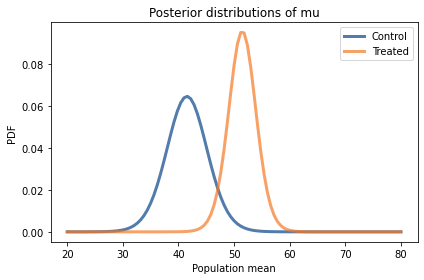

In [22]:
pmf_mean_control.plot(label='Control')
pmf_mean_treated.plot(label='Treated')

decorate(xlabel='Population mean', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

In both cases the posterior probabilities at the ends of the range are near zero, which means that the bounds we chose for the prior distribution are wide enough.

Comparing the marginal distributions for the two groups, it looks like the population mean in the treated group is higher.
We can use `prob_gt` to compute the probability of superiority:

In [23]:
Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

0.980479025187326

There is a 98% chance that the mean in the treated group is higher.

## Distribution of Differences

To quantify the magnitude of the difference between groups, we can use `sub_dist` to compute the distribution of the difference.

In [24]:
pmf_diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

There are two things to be careful about when you use methods like `sub_dist`. 
The first is that the result usually contains more elements than the original `Pmf`.  
In this example, the original distributions have the same quantities, so the size increase is moderate.

In [25]:
len(pmf_mean_treated), len(pmf_mean_control), len(pmf_diff)

(101, 101, 879)

In the worst case, the size of the result can be the product of the sizes of the originals.

The other thing to be careful about is plotting the `Pmf`.
In this example, if we plot the distribution of differences, the result is pretty noisy.

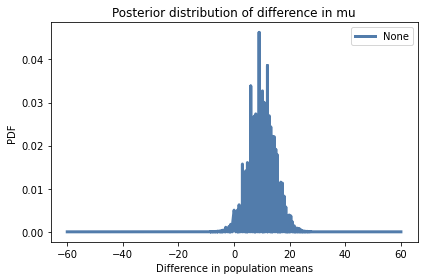

In [26]:
pmf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

There are two ways to work around that limitation.  One is to plot the CDF, which smooths out the noise:

In [27]:
cdf_diff = pmf_diff.make_cdf()

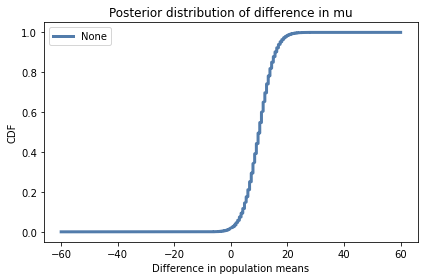

In [28]:
cdf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='CDF', 
         title='Posterior distribution of difference in mu')

The other option is to use kernel density estimation (KDE) to make a smooth approximation of the PDF on an equally-spaced grid, which is what this function does:

In [29]:
from scipy.stats import gaussian_kde

def kde_from_pmf(pmf, n=101):
    """Make a kernel density estimate for a PMF."""
    kde = gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

`kde_from_pmf` takes as parameters a `Pmf` and the number of places to evaluate the KDE.

It uses `gaussian_kde`, which we saw in <<_KernelDensityEstimation>>, passing the probabilities from the `Pmf` as weights.
This makes the estimated densities higher where the probabilities in the `Pmf` are higher.

Here's what the kernel density estimate looks like for the `Pmf` of differences between the groups.

In [30]:
kde_diff = kde_from_pmf(pmf_diff)

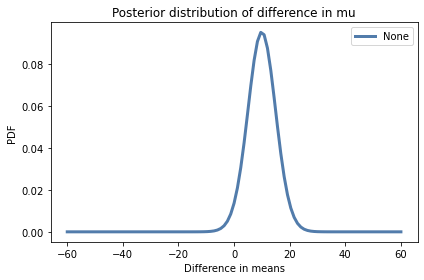

In [31]:
kde_diff.plot()

decorate(xlabel='Difference in means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

The mean of this distribution is almost 10 points on a test where the mean is around 45, so the effect of the treatment seems to be substantial.

In [32]:
pmf_diff.mean()

9.954413088940848

We can use `credible_interval` to compute a 90% credible interval.

In [33]:
pmf_diff.credible_interval(0.9)

array([ 2.4, 17.4])

Based on this interval, we are pretty sure the treatment improves test scores by 2 to 17 points.

## Using Summary Statistics

In this example the dataset is not very big, so it doesn't take too long to compute the probability of every score under every hypothesis.
But the result is a 3-D array; for larger datasets, it might be too big to compute practically.

Also, with larger datasets the likelihoods get very small, sometimes so small that we can't compute them with floating-point arithmetic.
That's because we are computing the probability of a particular dataset; the number of possible datasets is astronomically big, so the probability of any of them is very small.

An alternative is to compute a summary of the dataset and compute the likelihood of the summary.
For example, if we compute the mean and standard deviation of the data, we can compute the likelihood of those summary statistics under each hypothesis.

As an example, suppose we know that the actual mean of the population, $\mu$,  is 42 and the actual standard deviation, $\sigma$, is 17.

In [34]:
mu = 42
sigma = 17

Now suppose we draw a sample from this distribution with sample size `n=20`, and compute the mean of the sample, which I'll call `m`, and the standard deviation of the sample, which I'll call `s`.

And suppose it turns out that:

In [35]:
n = 20
m = 41
s = 18

The summary statistics, `m` and `s`, are not too far from the parameters $\mu$ and $\sigma$, so it seems like they are not too unlikely.

To compute their likelihood, we will take advantage of three results from mathematical statistics:

* Given $\mu$ and $\sigma$, the distribution of `m` is normal with parameters $\mu$ and $\sigma/\sqrt{n}$;

* The distribution of $s$ is more complicated, but if we compute the transform $t = n s^2 / \sigma^2$, the distribution of $t$ is chi-squared with parameter $n-1$; and

* According to [Basu's theorem](https://en.wikipedia.org/wiki/Basu%27s_theorem), `m` and `s` are independent.

So let's compute the likelihood of `m` and `s` given $\mu$ and $\sigma$.

First I'll create a `norm` object that represents the distribution of `m`.

In [36]:
dist_m = norm(mu, sigma/np.sqrt(n))

This is the "sampling distribution of the mean".
We can use it to compute the likelihood of the observed value of `m`, which is 41.

In [37]:
like1 = dist_m.pdf(m)
like1

0.10137915138497372

Now let's compute the likelihood of the observed value of `s`, which is 18.
First, we compute the transformed value `t`:

In [38]:
t = n * s**2 / sigma**2
t

22.422145328719722

Then we create a `chi2` object to represent the distribution of `t`:

In [39]:
from scipy.stats import chi2

dist_s = chi2(n-1)

Now we can compute the likelihood of `t`:

In [40]:
like2 = dist_s.pdf(t)
like2

0.04736427909437004

Finally, because `m` and `s` are independent, their joint likelihood is the product of their likelihoods:

In [41]:
like = like1 * like2
like

0.004801750420548287

Now we can compute the likelihood of the data for any values of $\mu$ and $\sigma$, which we'll use in the next section to do the update.

## Update with summary statistics

Now we're ready to do an update.
I'll compute summary statistics for the two groups.

In [42]:
summary = {}

for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
    
summary

{'Control': (23, 41.52173913043478, 17.148733229699484),
 'Treated': (21, 51.476190476190474, 11.00735684721381)}

The result is a dictionary that maps from group name to a tuple that contains the sample size, `n`, the sample mean, `m`, and the sample standard deviation `s`, for each group.

I'll demonstrate the update with the summary statistics from the control group.

In [43]:
n, m, s = summary['Control']

I'll make a mesh with hypothetical values of `mu` on the `x` axis and values of `sigma` on the `y` axis.

In [44]:
mus, sigmas = np.meshgrid(prior.columns, prior.index)
mus.shape

(101, 101)

Now we can compute the likelihood of seeing the sample mean, `m`, for each pair of parameters.

In [45]:
like1 = norm(mus, sigmas/np.sqrt(n)).pdf(m)
like1.shape

(101, 101)

And we can compute the likelihood of the sample standard deviation, `s`, for each pair of parameters.

In [46]:
ts = n * s**2 / sigmas**2
like2 = chi2(n-1).pdf(ts)
like2.shape

(101, 101)

Finally, we can do the update with both likelihoods:

In [47]:
posterior_control2 = prior * like1 * like2
normalize(posterior_control2)

0.00030965351017402847

And here's what the joint posterior distribution looks like for the control group.

To compute the posterior distribution for the treatment group, I'll put the previous steps in a function:

In [48]:
def update_norm_summary(prior, data):
    """Update a normal distribution using summary statistics."""
    n, m, s = data
    mu_mesh, sigma_mesh = np.meshgrid(prior.columns, prior.index)
    
    like1 = norm(mu_mesh, sigma_mesh/np.sqrt(n)).pdf(m)
    like2 = chi2(n-1).pdf(n * s**2 / sigma_mesh**2)
    
    posterior = prior * like1 * like2
    normalize(posterior)
    
    return posterior

Here's the update for the treatment group:

In [49]:
data = summary['Treated']
posterior_treated2 = update_norm_summary(prior, data)

And here are the results.

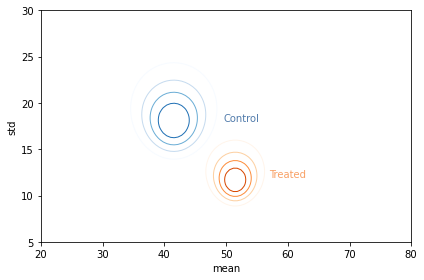

In [50]:
plot_contour(posterior_control2, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated2, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate()

Visually, these posterior joint distributions are similar to the ones we computed using the entire dataset, not just the summary statistics.
But they are not exactly the same, as we can see by comparing the marginal distributions.

## Comparing Marginals

Again, let's extract the marginal posterior distributions.

In [51]:
from utils import marginal

pmf_mean_control2 = marginal(posterior_control2, 0)
pmf_mean_treated2 = marginal(posterior_treated2, 0)

And compare them to results we got using the entire dataset (the dashed lines).

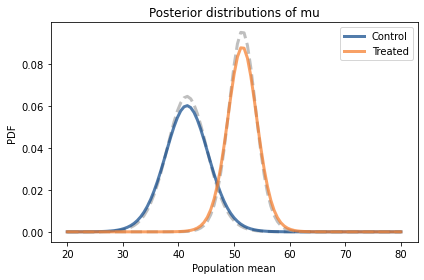

In [52]:
pmf_mean_control.plot(label='_nolegend', 
                      color='C5', linestyle='dashed')
pmf_mean_control2.plot(label='Control')
pmf_mean_treated.plot(label='_nolegend', 
                      color='C5', linestyle='dashed')
pmf_mean_treated2.plot(label='Treated')

decorate(xlabel='Population mean', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

The posterior distributions based on summary statistics are similar to the posteriors we computed using the entire dataset, but in both cases they are shorter and a little wider.

That's because the update with summary statistics is based on the implicit assumption that the distribution of the data is normal.
But it's not; as a result, when we replace the dataset with the summary statistics, we lose some information about the true distribution of the data.
With less information, we are less certain about the parameters.

## Proof By Simulation

The update with summary statistics is based on theoretical distributions, and it seems to work, but I think it is useful to test theories like this, for a few reasons:

* It confirms that our understanding of the theory is correct,

* It confirms that the conditions where we apply the theory are conditions where the theory holds, 

* It confirms that the implementation details are correct.  For many distributions, there is more than one way to specify the parameters.  If you use the wrong specification, this kind of testing will help you catch the error.

In this section I'll use simulations to show that the distribution of the sample mean and standard deviation is as I claimed.
But if you want to take my word for it, you can skip this section and the next.

Let's suppose that we know the actual mean and standard deviation of the population:

In [53]:
mu = 42
sigma = 17

I'll create a `norm` object to represent this distribution.

In [54]:
dist = norm(mu, sigma)

`norm` provides `rvs`, which generates random values from the distribution.
We can use it to simulate 1000 samples, each with sample size `n=20`.

In [55]:
n = 20
samples = dist.rvs((1000, n))
samples.shape

(1000, 20)

The result is an array with 1000 rows, each containing a sample or 20 simulated test scores.

If we compute the mean of each row, the result is an array that contains 1000 sample means; that is, each value is the mean of a sample with `n=20`.

In [56]:
sample_means = samples.mean(axis=1)
sample_means.shape

(1000,)

Now, let's compare the distribution of these means to `dist_m`.
I'll use `pmf_from_dist` to make a discrete approximation of `dist_m`:

In [57]:
def pmf_from_dist(dist, low, high):
    """Make a discrete approximation of a continuous distribution.
    
    dist: SciPy dist object
    low: low end of range
    high: high end of range
    
    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

`pmf_from_dist` takes an object representing a continuous distribution, evaluates its probability density function at equally space points between `low` and `high`, and returns a normalized `Pmf` that approximates the distribution.

I'll use it to evaluate `dist_m` over a range of six standard deviations.

In [58]:
low = dist_m.mean() - dist_m.std() * 3
high = dist_m.mean() + dist_m.std() * 3

pmf_m = pmf_from_dist(dist_m, low, high)

Now let's compare this theoretical distribution to the means of the samples.
I'll use `kde_from_sample` to estimate their distribution and evaluate it in the same locations as `pmf_m`.

In [59]:
from utils import kde_from_sample

qs = pmf_m.qs
pmf_sample_means = kde_from_sample(sample_means, qs)

The following figure shows the two distributions.

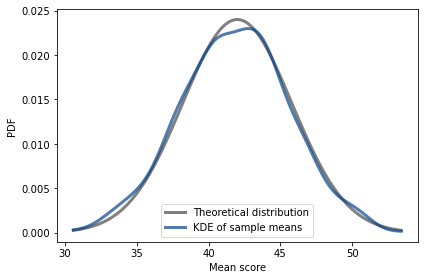

In [60]:
pmf_m.plot(label='Theoretical distribution',
           color='gray')
pmf_sample_means.plot(label='KDE of sample means')

decorate(xlabel='Mean score',
         ylabel='PDF')

The theoretical distribution and the distribution of sample means are in accord.

## Checking Standard Deviation

Let's also check that the standard deviations follow the distribution we expect.
First I'll compute the standard deviation for each of the 1000 samples.


In [61]:
sample_stds = samples.std(axis=1)
sample_stds.shape

(1000,)

Now we'll compute the transformed values, $t = n s^2 / \sigma^2$.

In [62]:
transformed = n * sample_stds**2 / sigma**2

We expect the transformed values to follow a chi-square distribution with parameter $n-1$.
SciPy provides `chi2`, which we can use to represent this distribution.

In [63]:
from scipy.stats import chi2

dist_s = chi2(n-1)

We can use `pmf_from_dist` again to make a discrete approximation.

In [64]:
low = 0
high = dist_s.mean() + dist_s.std() * 4

pmf_s = pmf_from_dist(dist_s, low, high)

And we'll use `kde_from_sample` to estimate the distribution of the sample standard deviations.

In [65]:
qs = pmf_s.qs
pmf_sample_stds = kde_from_sample(transformed, qs)

Now we can compare the theoretical distribution to the distribution of the standard deviations.

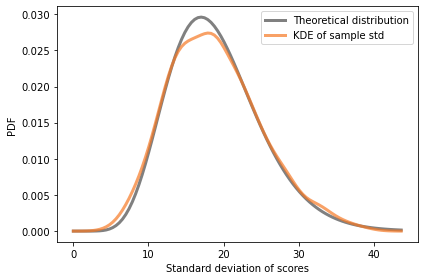

In [66]:
pmf_s.plot(label='Theoretical distribution',
           color='gray')
pmf_sample_stds.plot(label='KDE of sample std',
                     color='C1')

decorate(xlabel='Standard deviation of scores',
         ylabel='PDF')

The distribution of transformed standard deviations agrees with the theoretical distribution.

Finally, to confirm that the sample means and standard deviations are independent, I'll compute their coefficient of correlation:

In [67]:
np.corrcoef(sample_means, sample_stds)[0][1]

-0.02131902621728247

Their correlation is near zero, which is consistent with their being independent.

So the simulations confirm the theoretical results we used to do the update with summary statistics.

We can also use `kdeplot` from Seaborn to see what their joint distribution looks like.

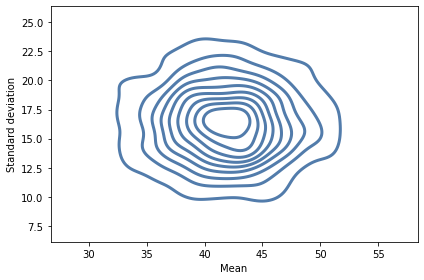

In [68]:
import seaborn as sns

sns.kdeplot(x=sample_means, y=sample_stds)

decorate(xlabel='Mean', ylabel='Standard deviation')

It looks like the axes of the ellipses are aligned with the axes, which indicates that the variables are independent.

## Summary

In this chapter we used a joint distribution to represent prior probabilities for the parameters of a normal distribution, `mu` and `sigma`.
And we updated that distribution two ways: first using the entire dataset and the normal PDF; then using summary statistics, the normal PDF, and the chi-square PDF.
Using summary statistics is computationally more efficient, but it loses some information in the process.

Normal distributions appear in many domains, so the methods in this chapter are broadly applicable.  The exercises at the end of the chapter will give you a chance to apply them.

## Exercises

**Exercise:** Looking again at the posterior joint distribution of `mu` and `sigma`, it seems like the standard deviation of the treated group might be lower; if so, that would suggest that the treatment is more effective for students with lower scores.

But before we speculate too much, we should estimate the size of the difference and see whether it might actually be 0.

Extract the marginal posterior distributions of `sigma` for the two groups.
What is the probability that the standard deviation is higher in the control group?

Compute the distribution of the difference in `sigma` between the two groups.  What is the mean of this difference?  What is the 90% credible interval?

In [69]:
# Solution

pmf_std_control = marginal(posterior_control, 1)
pmf_std_treated = marginal(posterior_treated, 1)

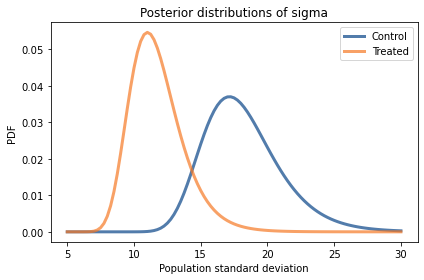

In [70]:
# Solution

pmf_std_control.plot(label='Control')
pmf_std_treated.plot(label='Treated')

decorate(xlabel='Population standard deviation', 
         ylabel='PDF', 
         title='Posterior distributions of sigma')

In [71]:
# Solution

Pmf.prob_gt(pmf_std_control, pmf_std_treated)

0.9685103375300469

In [72]:
# Solution

pmf_diff2 = Pmf.sub_dist(pmf_std_control, pmf_std_treated)

In [73]:
# Solution

pmf_diff2.mean()

6.41717132817218

In [74]:
# Solution

pmf_diff2.credible_interval(0.9)

array([ 1. , 12.5])

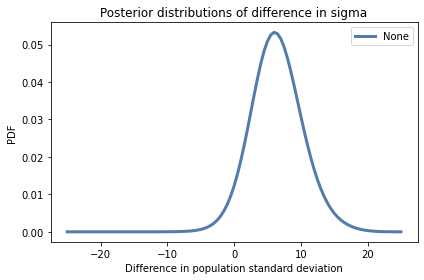

In [75]:
# Solution

kde_from_pmf(pmf_diff2).plot()

decorate(xlabel='Difference in population standard deviation', 
         ylabel='PDF', 
         title='Posterior distributions of difference in sigma')

## Exercise

An "[effect size](http://en.wikipedia.org/wiki/Effect_size)" is a statistic intended to quantify the magnitude of a phenomenon.
If the phenomenon is a difference in means between two groups, a common way to quantify it is Cohen's effect size, denoted $d$.

If the parameters for Group 1 are $(\mu_1, \sigma_1)$, and the
parameters for Group 2 are $(\mu_2, \sigma_2)$, Cohen's
effect size is

$ d = \frac{\mu_1 - \mu_2}{(\sigma_1 + \sigma_2)/2} $

Use the joint posterior distributions for the two groups to compute the posterior distribution for Cohen's effect size.

If we try enumerate all pairs from the two distributions, it takes too
long so we'll use random sampling.

The following function takes a joint posterior distribution and returns a sample of pairs.
It uses some features we have not seen yet, but you can ignore the details for now.

In [76]:
def sample_joint(joint, size):
    """Draw a sample from a joint distribution.
    
    joint: DataFrame representing a joint distribution
    size: sample size
    """
    pmf = Pmf(joint.transpose().stack())
    return pmf.choice(size)

Here's how we can use it to sample pairs from the posterior distributions for the two groups.

In [77]:
sample_treated = sample_joint(posterior_treated, 1000)
sample_treated.shape

(1000,)

In [78]:
sample_control = sample_joint(posterior_control, 1000)
sample_control.shape

(1000,)

The result is an array of tuples, where each tuple contains a possible pair of values for $\mu$ and $\sigma$.
Now you can loop through the samples, compute the Cohen effect size for each, and estimate the distribution of effect sizes.

In [79]:
# Solution

def cohen_effect(pair1, pair2):
    """Compute Cohen's effect size for difference in means.
    
    pair1: tuple of (mu1, sigma1)
    pair2: tuple of (mu2, sigma2)
    
    return: float
    """
    mu1, sigma1 = pair1 
    mu2, sigma2 = pair2
    sigma = (sigma1 + sigma2) / 2
    return (mu1 - mu2) / sigma

In [80]:
# Solution

cohen_effect(sample_treated[0], sample_control[0])

0.27096774193548406

In [81]:
# Solution

ds = []
for pair1, pair2 in zip(sample_treated, sample_control):
    d = cohen_effect(pair1, pair2)
    ds.append(d)

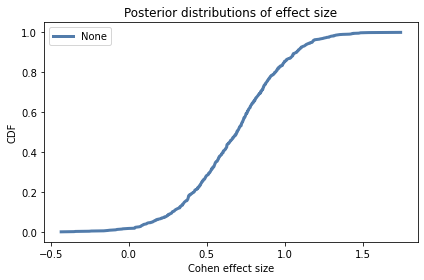

In [82]:
# Solution

cdf = Cdf.from_seq(ds)
cdf.plot()

decorate(xlabel='Cohen effect size',
         ylabel='CDF',
         title='Posterior distributions of effect size')

In [83]:
# Solution

cdf.mean()

0.6763828239272031

In [84]:
# Solution

cdf.credible_interval(0.9)

array([0.15238095, 1.17410072])

**Exercise:** This exercise is inspired by [a question that appeared on Reddit](https://www.reddit.com/r/statistics/comments/hcvl2j/q_reverse_empirical_distribution_rule_question/).

An instructor announces the results of an exam like this, "The average score on this exam was 81.  Out of 25 students, 5 got more than 90, and I am happy to report that no one failed (got less than 60)."

Based on this information, what do you think the standard deviation of scores was?

You can assume that the distribution of scores is approximately normal.  And let's assume that the sample mean, 81, is actually the population mean, so we only have to estimate `sigma`.

Hint: To compute the probability of a score greater than 90, you can use `norm.sf`, which computes the survival function, also known as the complementary CDF, or `1 - cdf(x)`.

In [85]:
# Solution

# Based on trial and error, here's a range of
# values for the prior

hypos = np.linspace(1, 51, 101)

In [86]:
# Solution

# Here are the probabilities of a score greater than 90
# for each hypothetical value of sigma.

from scipy.stats import norm

pgt90 = norm(81, hypos).sf(90)
pgt90.shape

(101,)

In [87]:
# Solution

# And here's the chance that 5 out of 25 people
# get a score greater than 90

from scipy.stats import binom

likelihood1 = binom(25, pgt90).pmf(5)
likelihood1.shape

(101,)

In [88]:
# Solution

# Here's the first update

prior = Pmf(1, hypos)
posterior = prior * likelihood1
posterior.normalize()

5.299480018256251

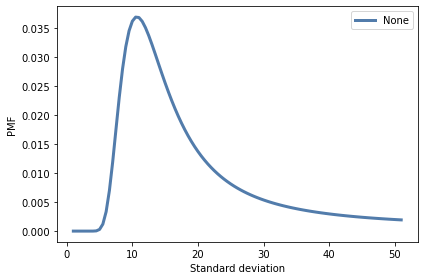

In [89]:
# Solution

# Here's the first posterior.

posterior.plot()
decorate(xlabel='Standard deviation',
         ylabel='PMF')

In [90]:
# Solution

# Here's the probability of a score greater than 60

pgt60s = norm(81, hypos).sf(60)

In [91]:
# Solution

# And here's the probability that all 25 students exceed 60

likelihood2 = pgt60s ** 25

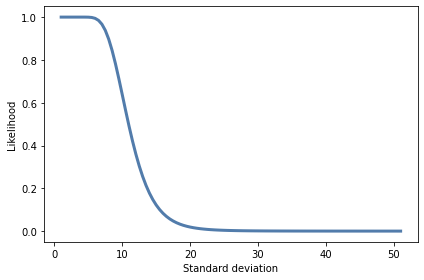

In [92]:
# Solution

plt.plot(hypos, likelihood2)
decorate(xlabel='Standard deviation',
         ylabel='Likelihood')

In [93]:
# Solution

# Here's the posterior after both updates

prior = Pmf(1, hypos)
prior.normalize()
posterior2 = prior * likelihood1 * likelihood2
posterior2.normalize()

0.014254555311295629

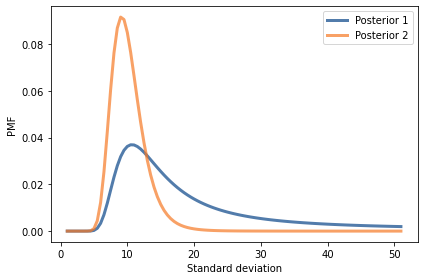

In [94]:
# Solution

posterior.plot(label='Posterior 1')
posterior2.plot(label='Posterior 2')

decorate(xlabel='Standard deviation',
         ylabel='PMF')

In [95]:
# Solution

posterior.mean(), posterior2.mean()

(18.150261186811544, 10.189707962198526)

In [96]:
# Solution

posterior2.credible_interval(0.9)

array([ 7., 15.])

**Exercise:** I have a soft spot for crank science, so this exercise is about the [Variability Hypothesis](http://en.wikipedia.org/wiki/Variability_hypothesis), which

> "originated in the early nineteenth century with Johann Meckel, who argued that males have a greater range of ability than females, especially in intelligence. In other words, he believed that most geniuses and most mentally retarded people are men. Because he considered males to be the ’superior animal,’ Meckel concluded that females’ lack of variation was a sign of inferiority."

I particularly like that last part because I suspect that if it turned out that women were _more_ variable, Meckel would have taken that as a sign of inferiority, too. 

Nevertheless, the Variability Hypothesis suggests an exercise we can use to practice the methods in this chapter.  Let's look at the distribution of heights for men and women in the U.S. and see who is more variable.

I used 2018 data from the CDC’s [Behavioral Risk Factor Surveillance System](https://www.cdc.gov/brfss/annual_data/annual_2018.html) (BRFSS), which includes self-reported heights from 154407 men and 254722 women. 

Here's what I found:

* The average height for men is 178 cm; the average height for women is 163 cm. So men are taller on average; no surprise there.

* For men the standard deviation is 8.27 cm; for women it is 7.75 cm. So in absolute terms, men's heights are more variable.

But to compare variability between groups, it is more meaningful to use the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) (CV), which is the standard deviation divided by the mean. It is a dimensionless measure of variability relative to scale. 

For men CV is 0.0465; for women it is 0.0475.
The coefficient of variation is higher for women, so this dataset provides evidence against the Variability Hypothesis. But we can use Bayesian methods to make that conclusion more precise.

Use these summary statistics to compute the posterior distribution of `mu` and `sigma` for the distributions of male and female height.
Use `Pmf.div_dist` to compute posterior distributions of CV.
Based on this dataset and the assumption that the distribution of height is normal, what is the probability that the coefficient of variation is higher for men?
What is the most likely ratio of the CVs and what is the 90% credible interval for that ratio?

Hint: Use different prior distributions for the two groups, and chose them so they cover all parameters with non-negligible probability.

Also, you might find this function helpful:

In [97]:
def get_posterior_cv(joint):
    """Get the posterior distribution of CV.
    
    joint: joint distribution of mu and sigma
    
    returns: Pmf representing the smoothed posterior distribution
    """
    pmf_mu = marginal(joint, 0)
    pmf_sigma = marginal(joint, 1)
    pmf_cv = Pmf.div_dist(pmf_sigma, pmf_mu)
    return kde_from_pmf(pmf_cv)

In [98]:
# Solution

n = 154407
mean = 178
std = 8.27

In [100]:
# Solution

qs = np.linspace(mean-0.1, mean+0.1, num=101)
prior_mu = make_uniform(qs, name='mean')

qs = np.linspace(std-0.1, std+0.1, num=101)
prior_sigma = make_uniform(qs, name='std')

prior = make_joint(prior_mu, prior_sigma)

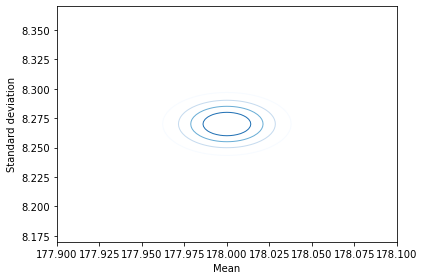

In [101]:
# Solution

data = n, mean, std
posterior_male = update_norm_summary(prior, data)
plot_contour(posterior_male, cmap='Blues')
decorate(xlabel='Mean', ylabel='Standard deviation')

In [102]:
# Solution

n = 254722
mean = 163
std = 7.75

In [104]:
# Solution

qs = np.linspace(mean-0.1, mean+0.1, num=101)
prior_mu = make_uniform(qs, name='mean')

qs = np.linspace(std-0.1, std+0.1, num=101)
prior_sigma = make_uniform(qs, name='std')

prior = make_joint(prior_mu, prior_sigma)

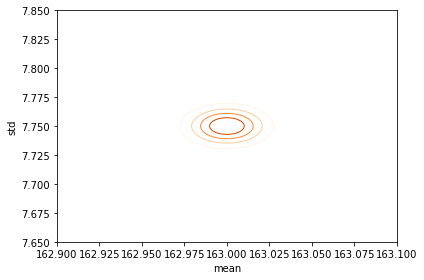

In [105]:
# Solution

data = n, mean, std
posterior_female = update_norm_summary(prior, data)
plot_contour(posterior_female, cmap='Oranges');

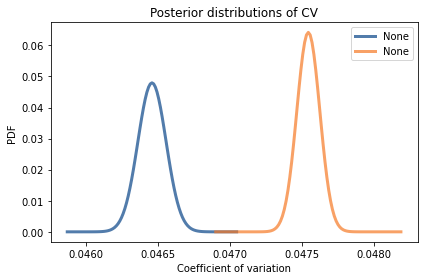

In [106]:
# Solution

pmf_cv_male = get_posterior_cv(posterior_male)
kde_from_pmf(pmf_cv_male).plot()

pmf_cv_female = get_posterior_cv(posterior_female)
kde_from_pmf(pmf_cv_female).plot()

decorate(xlabel='Coefficient of variation',
         ylabel='PDF',
         title='Posterior distributions of CV')

In [107]:
# Solution

ratio_cv = Pmf.div_dist(pmf_cv_female, pmf_cv_male)
ratio_cv.max_prob()

1.0233615721208176

In [108]:
# Solution

ratio_cv.credible_interval(0.9)

array([1.0193799 , 1.02734473])